# SCC-ICMC-USP - 1o. semestre de 2023
# SCC5948/MAI5024 - CIENCIA DE DADOS
## **Exercício 5**
##**CURVAS ROC**

### Profa. Roseli A. F. Romero

### Monitor: Diogo Godoi

Nro do grupo: 05

Alunos:

1.   Gabriel Bortoli - 5378290
2.   Lucas Maretti - 6789752


#Curva ROC e Teste de hipótese

## Funções novas utilizadas no exercício

- `pandas.Series.nunique()` ([link](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.nunique.html)): Conta quantidade de valores únicos de uma coluna. 
- `scipy.stats.ttest_ind()` ([link](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html#scipy.stats.ttest_ind)): Calcula o teste t para duas amostras independentes
- `sklearn.metrics.plot_roc_curve()` ([link](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_roc_curve.html)): Plota a curva ROC de um classificador dado um conjunto de input e alvo

O DATASET A SER UTILIZADO É O TITANIC.CSV disponivel já disponivel na biblioteca pandas.

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as mn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn import datasets, metrics, model_selection, svm
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from scipy.stats import ttest_ind

from sklearn.datasets import fetch_openml

In [85]:
X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True, parser="auto")

X.head()

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


### Questão 01.

Faça a exploração dos dados. Isto é, carregue, substitua valores faltantes, padronize os dados, etc. Faça também a seleção dos atributos que achar mais relevantes. 

 - Dica: Utilize a função `nunique()` durante a exploração dos dados. Você pode utilizar o "bom senso" (além de outras ferramentas é claro) na hora de escolher qual atributo do conjunto manter

In [86]:
df = pd.concat([X, y], axis=1)
df.info()
df.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   pclass     1309 non-null   int64   
 1   name       1309 non-null   object  
 2   sex        1309 non-null   category
 3   age        1046 non-null   float64 
 4   sibsp      1309 non-null   int64   
 5   parch      1309 non-null   int64   
 6   ticket     1309 non-null   object  
 7   fare       1308 non-null   float64 
 8   cabin      295 non-null    object  
 9   embarked   1307 non-null   category
 10  boat       486 non-null    object  
 11  body       121 non-null    float64 
 12  home.dest  745 non-null    object  
 13  survived   1309 non-null   category
dtypes: category(3), float64(3), int64(3), object(5)
memory usage: 116.8+ KB


pclass          3
name         1307
sex             2
age            98
sibsp           7
parch           8
ticket        929
fare          281
cabin         186
embarked        3
boat           27
body          121
home.dest     369
survived        2
dtype: int64

<AxesSubplot: >

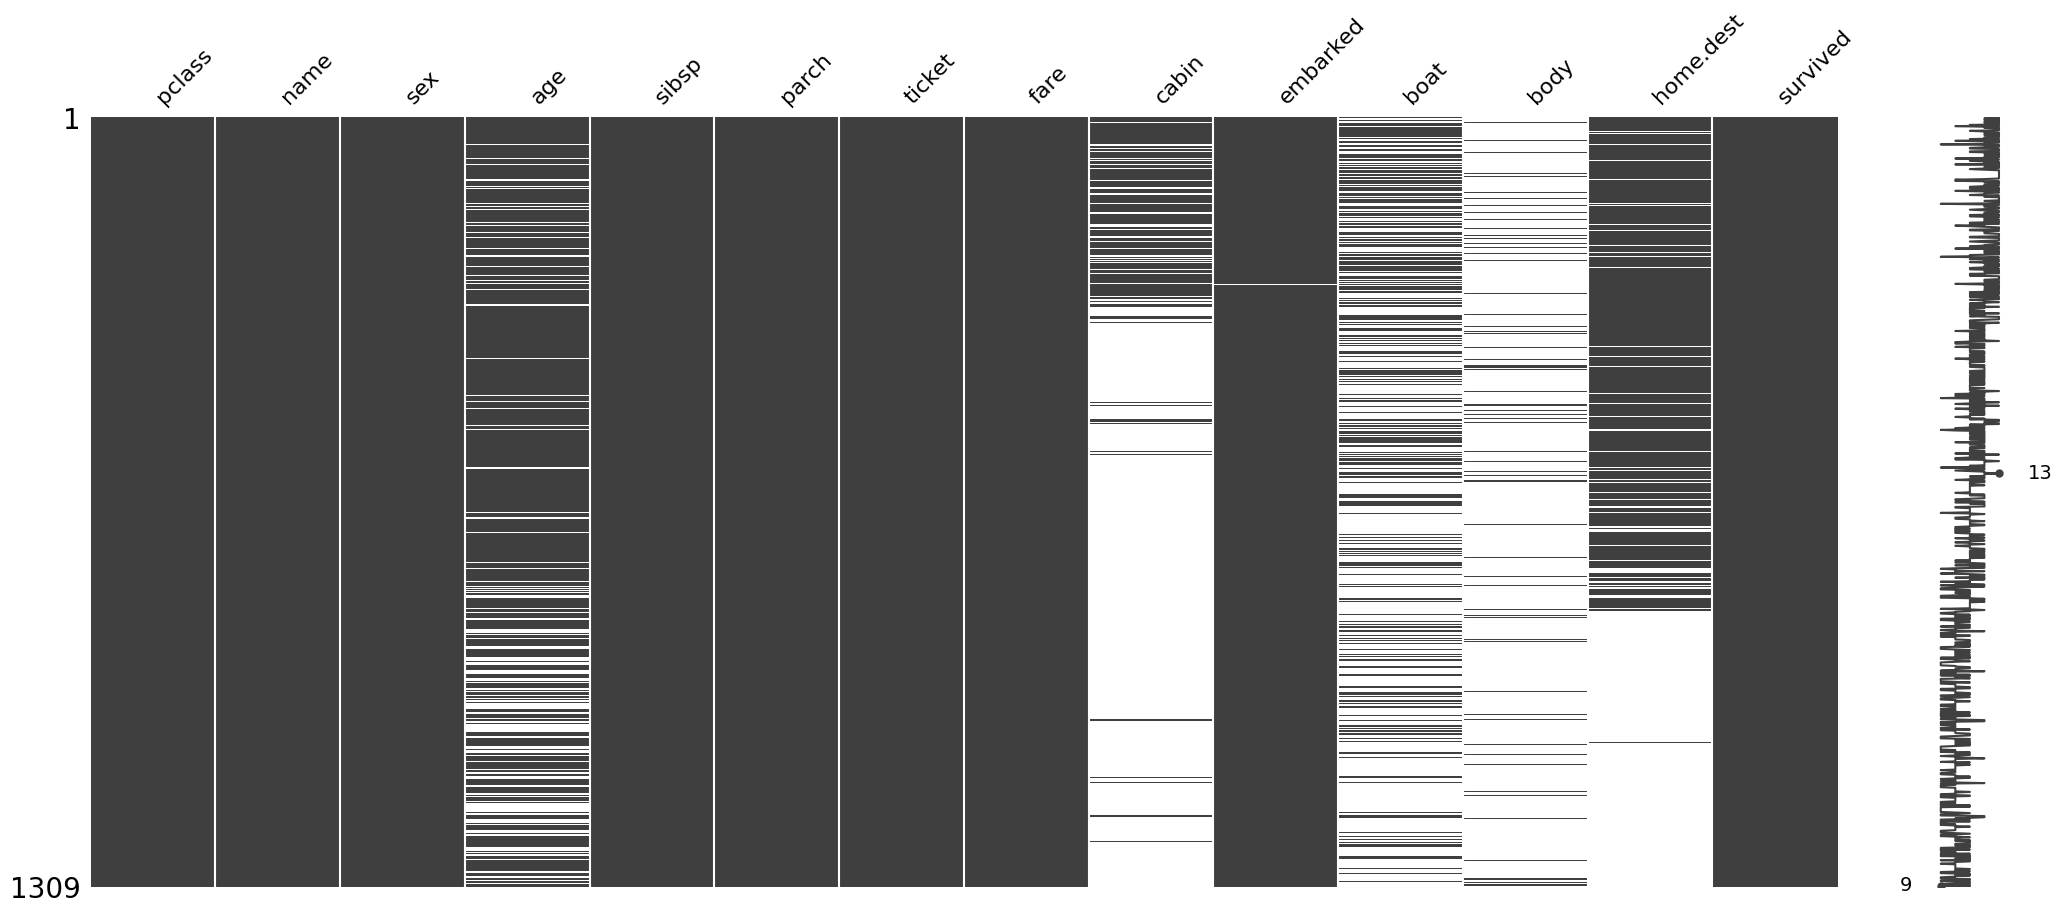

In [87]:
mn.matrix(df)

In [88]:
# Etapas de pré-processamento que podem ser feitas antes de separar em treino/teste vão aqui

# Excluindo colunas com pouca relevância ou muitos dados faltantes:
dft = df.drop(["name", "ticket", "cabin", "boat", "body", "home.dest"], axis=1)

# Unindo as colunas com o tamanho da família (conjuge/pais/filhos):
dft["fam_size"] = dft["sibsp"] + dft["parch"] + 1  # 1 é a própria pessoa
dft["fam_size"] = pd.to_numeric(dft["fam_size"], downcast="integer")
dft = dft.drop(["sibsp", "parch"], axis=1)

# Alterando a classe (1st/2nd/3rd) para categórico:
dft["pclass"] = dft["pclass"].astype("category")

# Completando os valores faltantes, com a mediana/valor mais comum dos "pares" em grupos semelhantes (sexo/classe/local de embarque):
# Observação: achamos melhor fazer isso aqui e não com um pipeline no pré-processamento com split treino/teste já feito, pois conseguimos uma maior precisão com o groupby.
dft["age"] = dft["age"].fillna(
    dft.groupby(["sex", "pclass", "embarked"])["age"].transform("median")
)
dft["fare"] = dft["fare"].fillna(
    dft.groupby(["sex", "pclass", "embarked"])["fare"].transform("median")
)
dft["embarked"] = dft["embarked"].fillna(
    dft.groupby(["age", "pclass"])["embarked"].transform(lambda x: x.mode().iat[0])
)

dft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   pclass    1309 non-null   category
 1   sex       1309 non-null   category
 2   age       1309 non-null   float64 
 3   fare      1309 non-null   float64 
 4   embarked  1309 non-null   category
 5   survived  1309 non-null   category
 6   fam_size  1309 non-null   int8    
dtypes: category(4), float64(2), int8(1)
memory usage: 27.5 KB


In [89]:
# Separação entre atributos e target:
X_proc = dft.drop("survived", axis=1)
y_proc = dft["survived"].astype("int64")

# Divisão entre treino e teste:
X_train, X_test, y_train, y_test = train_test_split(
    X_proc, y_proc, shuffle=True, stratify=y, test_size=0.2, random_state=42
)

In [90]:
# Etapas de pré-processamento que serão feitas após os dados estarem divididos em treino/teste

# Separação em features categórios e numéricos:
features_categoricos = X_train.select_dtypes(include=["category"]).columns.to_list()
features_numericos = X_train.select_dtypes(include=["number"]).columns.to_list()

In [91]:
# Função de pré-processamento com os dados já separados:
# Observação: não achamos necessário mandar os targets (y) como parâmetros e como retorno, pois eles não serão alterados (não vamos excluir linhas, por exemplo).

def preprocess(X_train, X_test, features_categoricos, features_numericos):
    # Criando os pipelines
    # Classes categóricas processadas com one-hot-enconder
    # Classes numéricas com MinMax Scaler (valores ficarão entre 0 e 1, para acompanhar as variáveis categóricas)
    pipe_cat = Pipeline(steps=[("onehot", OneHotEncoder())])
    pipe_num = Pipeline(steps=[("scaler", MinMaxScaler())])

    # Criando a transformação do conjunto de dados:
    transform = ColumnTransformer(
        transformers=[
            ("transf cat", pipe_cat, features_categoricos),
            ("transf num", pipe_num, features_numericos),
        ]
    )

    # Aplicando a transformação no dataset:
    X_modf_train = transform.fit_transform(X_train).round(4)
    X_modf_test = transform.fit_transform(X_test).round(4)

    # Definindo os nomes das colunas:
    names = []

    # Para os dados categóricos devemos acessar o transformador:
    transf_cat = transform.transformers_[0]
    # Depois o pipeline
    pipe_cat = transf_cat[1]
    # E finalmente o onehot
    transf_onehot = pipe_cat.named_steps["onehot"]
    # Para acessar o nome das variáveis usamos o método get_feature_names()
    names = names + (transf_onehot.get_feature_names_out().tolist())

    # Variáveis numéricas não tem alteração de tamanho, logo:
    names = names + features_numericos.copy()

    X_ready_train = pd.DataFrame(data=X_modf_train, columns=names)
    X_ready_test = pd.DataFrame(data=X_modf_test, columns=names)

    return X_ready_train, X_ready_test

In [92]:
# Fazendo o pré processamento usando a função criada (2a etapa, com conjuntos divididos):

X_modf_train, X_modf_test = preprocess(
    X_train, X_test, features_categoricos, features_numericos
)

In [93]:
# Aqui podemos validar alguns dados. Por exemplo: a soma da média das 3 pclass, assim como os 2 sex e os 3 embarked são iguais a 1.
# Também vemos que os valores min e max das variáveis numéricas são 0 e 1 respectivamente.
# Observação: estamos visualizando apenas o conjunto de treino, mas o de teste segue o mesmo.

X_modf_train.describe()

,pclass_1,pclass_2,pclass_3,sex_female,sex_male,embarked_C,embarked_Q,embarked_S,age,fare,fam_size
count,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000,1047.000000
mean,0.237822,0.210124,0.552053,0.355301,0.644699,0.204394,0.098376,0.697230,0.358221,0.062737,0.087011
std,0.425953,0.407591,0.497521,0.478833,0.478833,0.403450,0.297965,0.459676,0.165367,0.095442,0.156024
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.272000,0.015400,0.000000
50%,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.309600,0.026900,0.000000
75%,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.447700,0.060200,0.100000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [94]:
# Vemos também os tipos das classes após pré processamento, bem como ausência de dados faltantes e divisão entre treino/teste:
# Obsevação: novamente, mostramos apenas um conjunto, nesse caso, de teste.

X_modf_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262 entries, 0 to 261
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   pclass_1    262 non-null    float64
 1   pclass_2    262 non-null    float64
 2   pclass_3    262 non-null    float64
 3   sex_female  262 non-null    float64
 4   sex_male    262 non-null    float64
 5   embarked_C  262 non-null    float64
 6   embarked_Q  262 non-null    float64
 7   embarked_S  262 non-null    float64
 8   age         262 non-null    float64
 9   fare        262 non-null    float64
 10  fam_size    262 non-null    float64
dtypes: float64(11)
memory usage: 22.6 KB


### Questão 02.

Separe o conjunto de dados de maneira estratificada (através do parâmetro `stratify` da função `train_test_split`) em 20% para teste e 80% para treino. Depois plote a curva ROC (`sklearn.metrics.plot_roc_curve`) para **todos** os classificadores (no mesmo gráfico). 

Os melhores classificadores da questão anterior também apresentaram melhor desempenho na curva ROC? O que pode ter ocorrido? Teste diferentes valores de `random_state` na função `train_test_split` e observe o comportamento das curvas.


*   Dica: Para plotar múltiplas curvas ROC no mesmo gráfico, defina uma figura com `fig, ax = plt.subplots()` e passe `ax` como parâmetro da função `plot_roc_curve`. Não se esqueça de passar também o nome do classificador para que o seu gráfico fique mais fácil de interpretar



In [95]:
# Separação dos conjuntos foi feito previamente, antes de aplicar o pré-processamento.
# Nos dados observados aqui, o modelo com árvore de decisão foi superior ao Perceptron, ao contrário do observado no exercício anterior.
# Talvez pelo tipo/quantidade de dados, ou pelo uso do critério Gini (não usado anteriormente).
# Também fizemos testes com o random-state variado (usamos 0, 1, 14, 42, 99) e as diferenças foram pequenas, ainda que notáveis, chegando a mais de 10% no Perceptron usando de 99 (0.661) para 42 (0.7488), por exemplo.
# Optamos por deixar em 42, seguindo a "tendência" de uso (e viva Douglas Adams!).

# Também tivemos algumas modificações necessárias como:
# - Uso da função roc_curve ao invés de plot_roc_curve, que está desatualizada (v1.0 e atual é a v1.2).
# - Também usamos o modelo Random Forest, apenas para efeito de comparação, já que é bastante conhecido e usado.
# - Também precisamos verificar se a função 'predict_proba' estava disponível, já que em alguns modelos ela não é implementada. Nesses casos, usamos apenas o 'predict'.

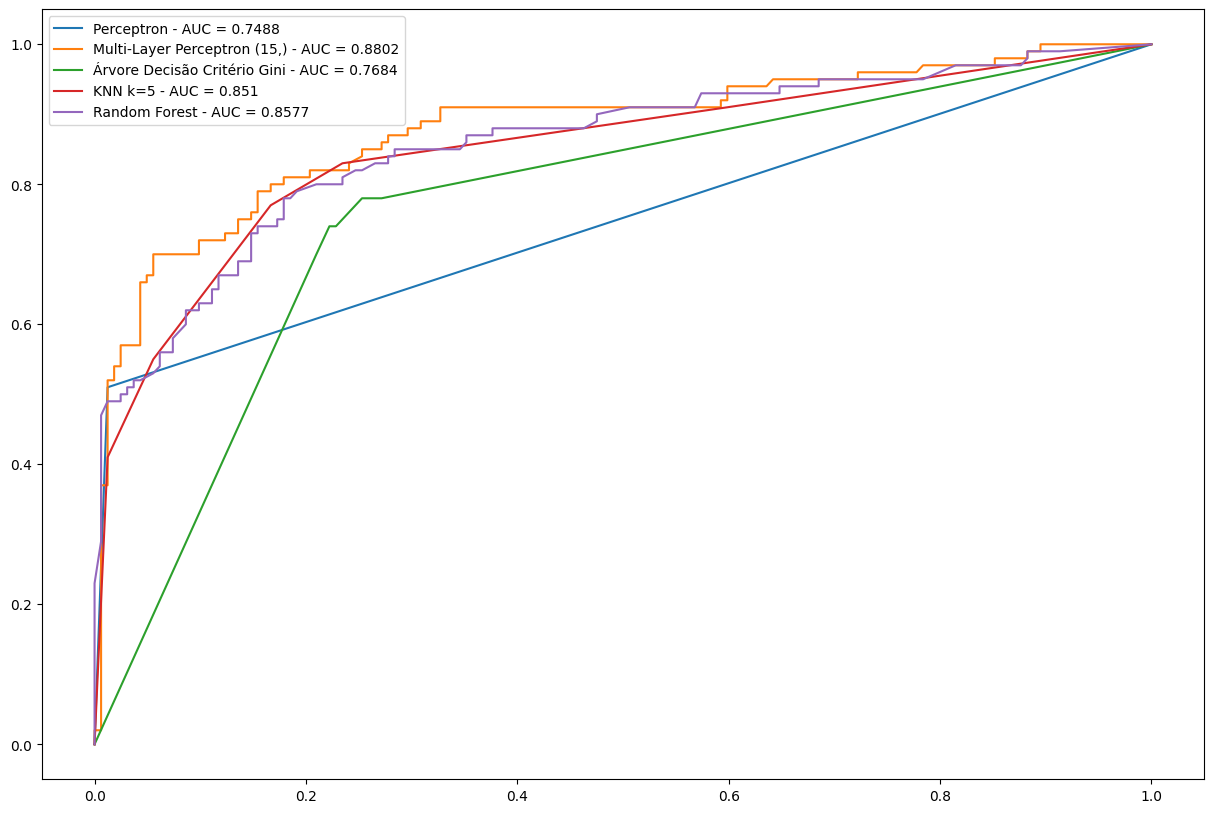

In [96]:
classificadores = {
    "Perceptron": {"modelo": Perceptron(), "scores": []},
    "Multi-Layer Perceptron (15,)": {"modelo": MLPClassifier(random_state=1, hidden_layer_sizes=(15,), max_iter=2000), "scores": []},
    "Árvore Decisão Critério Gini": {"modelo": DecisionTreeClassifier(criterion="gini"), "scores": []},
    "KNN k=5": {"modelo": KNeighborsClassifier(n_neighbors=5), "scores": []},
    "Random Forest": {"modelo": RandomForestClassifier(random_state=42), "scores": []}
}

plt.rcParams["figure.figsize"] = [15, 10]

for classificador_name in classificadores:
    model = classificadores[classificador_name]["modelo"]
    model.fit(X_modf_train, y_train)
    if hasattr(model, "predict_proba"):
        y_pred = model.predict_proba(X_modf_test)[:, 1]
    else:
        y_pred = model.predict(X_modf_test)
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
    auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
    #classificadores[classificador_name]["scores"].append(auc)
    plt.plot(fpr, tpr, label=classificador_name + " - AUC = " + str(auc))
    plt.legend()

plt.show()

### Questão 03.

Implemente o 10-Fold Cross Validation (pode usar o scikit) com os dois melhores classificadores de acordo com a curva ROC e guarde a acurácia de cada fold na chave 'scores' do dicionário de classificadores.

In [97]:
# Antes de utilizar o método, vamos voltar a unir os dataframes de treino/teste, uma vez que a separação será feita pelo próprio KFold:
X_kfold = pd.concat([X_modf_train, X_modf_test], axis=0)
y_kfold = pd.concat([y_train, y_test], axis=0)

X_kfold.info()
y_kfold.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 261
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   pclass_1    1309 non-null   float64
 1   pclass_2    1309 non-null   float64
 2   pclass_3    1309 non-null   float64
 3   sex_female  1309 non-null   float64
 4   sex_male    1309 non-null   float64
 5   embarked_C  1309 non-null   float64
 6   embarked_Q  1309 non-null   float64
 7   embarked_S  1309 non-null   float64
 8   age         1309 non-null   float64
 9   fare        1309 non-null   float64
 10  fam_size    1309 non-null   float64
dtypes: float64(11)
memory usage: 122.7 KB
<class 'pandas.core.series.Series'>
Int64Index: 1309 entries, 999 to 203
Series name: survived
Non-Null Count  Dtype
--------------  -----
1309 non-null   int64
dtypes: int64(1)
memory usage: 20.5 KB


In [98]:
# Top2 classificadores (não considerando o Random Forest, que não estava no escopo inicial):

top_class = {
    "Multi-Layer Perceptron (15,)": {"modelo": MLPClassifier(random_state=1, hidden_layer_sizes=(15,), max_iter=2000), "scores": []},
    "KNN k=5": {"modelo": KNeighborsClassifier(n_neighbors=5), "scores": []},
}

# Método de Cross Validation:
cv = KFold(n_splits=10, random_state=42, shuffle=True)

# Looping para avaliar todos os modelos:
for class_name in top_class:
    model = top_class[class_name]["modelo"]
    scores = cross_val_score(model, X_kfold, y_kfold, scoring="accuracy", cv=cv, n_jobs=-1)
    top_class[class_name]["scores"].append(scores)

for class_name in top_class:
    print(f"Modelo: {class_name} - Acurácia (desvio padrão): {round(np.mean(top_class[class_name]['scores']),3)} ({round(np.std(top_class[class_name]['scores']),3)})")
    print("Score por iteração: ", top_class[class_name]["scores"],"\n")

Modelo: Multi-Layer Perceptron (15,) - Acurácia (desvio padrão): 0.801 (0.021)
Score por iteração:  [array([0.79389313, 0.83969466, 0.77099237, 0.80916031, 0.79389313,
       0.80152672, 0.82442748, 0.81679389, 0.77099237, 0.79230769])] 

Modelo: KNN k=5 - Acurácia (desvio padrão): 0.8 (0.015)
Score por iteração:  [array([0.79389313, 0.82442748, 0.77862595, 0.78625954, 0.80916031,
       0.80916031, 0.78625954, 0.78625954, 0.81679389, 0.80769231])] 



### Questão 04.

Verifique se há diferença estatística significante entre suas acurácias da questão anterior utilizando o teste T (`scipy.stats.ttest_ind`). Considere que há diferença significante se p <= 0.05 (rejeita-se a hipótese nula)

In [99]:
# Colhendo os dados para comparação:
amostra1 = top_class["Multi-Layer Perceptron (15,)"]["scores"][0]
amostra2 = top_class["KNN k=5"]["scores"][0]

# Executando o teste:
ttest_ind(amostra1, amostra2)

Ttest_indResult(statistic=0.17820300336467143, pvalue=0.8605537957484947)

In [100]:
# Como o valor de P é bem alto, (0.86, quando a diferença seria considerada se p fosse menor que 0.05), podemos considerar que não há diferença estatística significante entre as acurácias.